In [1]:
import numpy as np
import sys
sys.path.append("..")
from allthethings import PyNetwork, PyPipe_ps
from allthethings import PyBC_opt_dh

import matplotlib.pyplot as plt
%pylab inline
from scipy import interpolate
from writeit import rewritePipes
from matplotlib import rc
rc('font', family='serif',size= '16')
from matplotlib import cm
import matplotlib.colors as colors  



Populating the interactive namespace from numpy and matplotlib


In [2]:
def idx_t(i,j,n,N):
    return (2*(N+2)*n+(N+2)*i+j)

In [3]:
fs = [1252373.8338904483, 1356857.8905686105, 772612.65870454395,1054423.970712,
      1054423.970712, 2100612.62756,674056.8721,672068.370296,672311.090218,
      668055.448081     ]
z0s = [(20,5), #IC (led to z0s[4] after 1 iteration
       (13.59689658,   9.93095919,   9.19104454,   4.51006466),#IC (broke)
       (4.09306869,  10.09743322), #IC (broke)
       (11.80949788,  5.       ),
       (19.67658839,  20.55368162 , 17.1443009,   18.20337988), #YOLO
       (12.21329178,   5.99595438),
        (19.09649799 , 13.73786189),
        (20.9923385,    6.08538151),
        (9.97540855 , 14.69335959),
      ]


In [4]:
Nn = 11
Nstar = 1
Np = Nn-1

J = 5#which pipe to sample at
xs = []
Mi = 10
L = 50
N = L
D= 0.1
T = 100
a = 100
Mr = 0.007
dx = L/float(N)
M = max(int(T*a/(dx*.8))*5,1)
Qin =0.0087
Ain =  0.00793018096379
h0 =0
dt = T/float(M)
Ns = [N]*Np
Ls = [L]*Np
Mrs = [Mr]*Np  #manning roughness coeffs
Ds = [D]*Np      #pipe diameter (m) 
h0s = [h0]*Np    #IC for h
q0s = [0]*Np    #IC for Q
jt = [1]+[2]*(Nn-2)+[1]  #for DFDpleasework2.inp
bt = [1]*Nn
bt[0] = 0
bv = [0]+[1]*(Nn-1)
r =  [0]+[1]*(Nn-2)+[-1]
oldinp = "../indata/DFDpleasework8.inp"
fn = "../indata/optim_elev_test"
H5 = np.zeros((9*Np,M/Mi))
freal = np.zeros(9)

for m in range(0,9):
    MM = m
    z = z0s[MM]
    f = fs[MM]

    K = len(z)+2
    if K ==6:
        e0,e1,e2,e3=z
        y = [25,e0,e1,0,e2,e3,15]
    elif K==4:
        e0,e1, = z
        y = [25,e0,0,e1,15]

    x = linspace(-1,1,K+1)
    t = linspace(-1,1,Nn)
    s = interpolate.splrep(x,y,s=0)
    elevs = interpolate.splev(t,s,der=0)
    Ltot = 0
    E = elevs[0]
    
    (fi, fc) = rewritePipes(fn,oldinp, Ns, Ls, Mrs, Ds, jt, bt, bv, r, h0s, q0s, T, M, a, elevs)
    n1 = PyNetwork(fi,fc,1)

    b00 = Ain*np.ones(M+1)
    n1.setbVal(0,b00)

    A00 = np.ones(N)*Ain
    Q00 = np.ones(N)*Qin
    n1.setIC(0,Q00,A00)
    n1.runForwardProblem(dt)
    freal[m] = sum([n1.getAveGradH(i) for i in range(M+1)])
    for J in range(Np):
        qh = n1.qhist(J)
        p0 = PyPipe_ps(N,n1.Ds[J], n1.Ls[J],M,a)
        H5[m*Np+J,:] = [p0.pbar(qh[idx_t(0,Nstar,n,n1.Ns[J])],False) for n in range(1,M+1,Mi)]
    

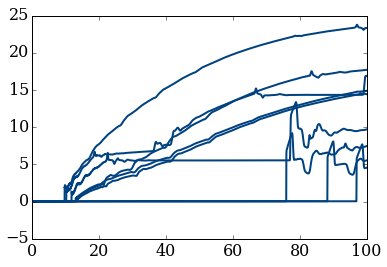

In [15]:
print shape(H5)

(90, 6250)


TypeError: float argument required, not numpy.ndarray

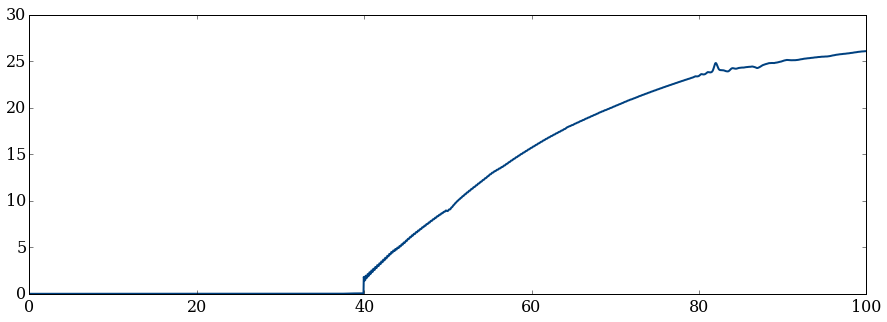

In [6]:
from matplotlib import cm
Nstar = 1
import matplotlib.colors as colors  
cNorm  = colors.Normalize(vmin=0, vmax=10)
scalarMap = cm.ScalarMappable(norm=cNorm, cmap=cm.get_cmap('ocean'))
Mi = 10
m = 0
Nt = 1
t = linspace(0,T,M/Mi)
fig,ax = plt.subplots(nrows=1, figsize=(15,5))
Hs =np.ndarray((Np,M/Mi*Nt))
for j in range(5,6):
    N = n1.Ns[j]
    p0 = PyPipe_ps(N,n1.Ds[j], n1.Ls[j],M,a)
    qh = n1.qhist(j)
    Htemp = [p0.pbar(qh[idx_t(0,Nstar,n,n1.Ns[j])],False) for n in range(1,M+1,Mi)]
    Hs[j,m*(M/Mi):(M/Mi)*(m+1)] = Htemp
    plot(t,Hs[j,:], color = scalarMap.to_rgba(j), label = '%d'%j, lw =2)
    title('f = %.3e'%freal)
#legend()
ylim(0,30)
xlabel('t (s)')
ylabel('P (psi)')
#savefig('/Users/anna/Desktop/pressures%d_ic_.eps'%MM,format='eps')

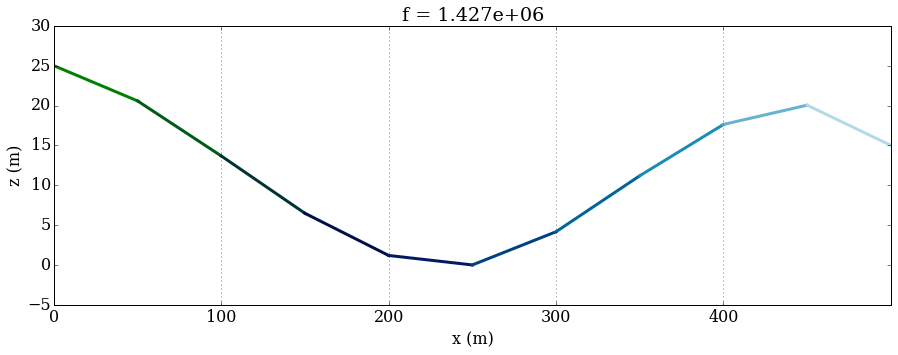

In [23]:

fig,ax = plt.subplots(nrows=1, figsize=(15,5))
E = elevs[0]
for k in range(Nn-1):
    L = 10
    x = linspace(0,L)
    cval = scalarMap.to_rgba(k)
    ax.plot(x+Ltot,x*(elevs[k+1]-elevs[k])/L+E,color = cval, lw = 3)
    xs.append(Ltot)
    Ltot+=L
    E = elevs[k+1]
xs.append(Ltot)
#gca().set_xticks(xs);
gca().xaxis.grid(True)
gca().set_xticklabels(arange(0,500,100));
gca().set_ylim(-5,30)
title('f = %.3e'%freal[m])
xlabel('x (m)')
ylabel('z (m)')
#savefig('/Users/anna/Desktop/profile%d_ic_.eps'%MM,format='eps')

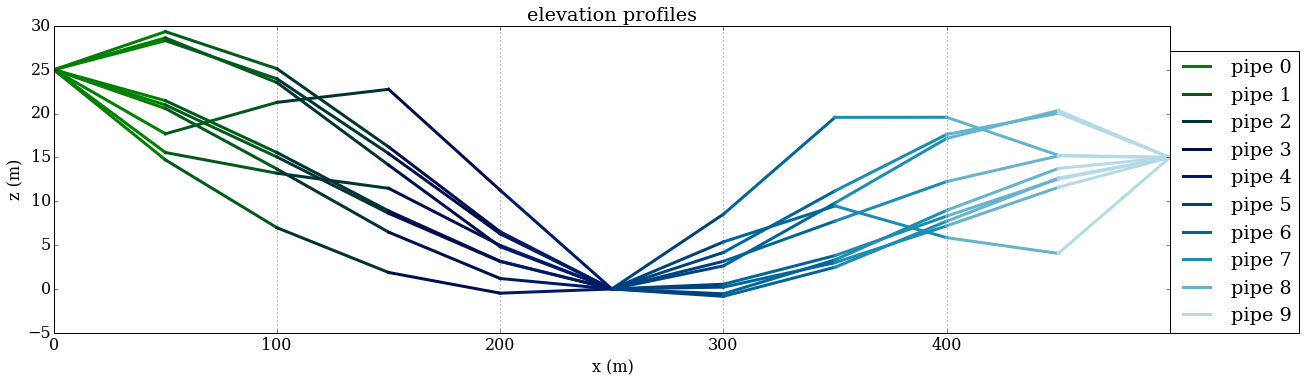

In [48]:
fig,ax = plt.subplots(nrows=1, figsize=(20,5.5))

for m in range(9):
    MM = m
    z = z0s[MM]
    f = fs[MM]

    K = len(z)+2
    if K ==6:
        e0,e1,e2,e3=z
        y = [25,e0,e1,0,e2,e3,15]
    elif K==4:
        e0,e1, = z
        y = [25,e0,0,e1,15]

    x = linspace(-1,1,K+1)
    t = linspace(-1,1,Nn)
    s = interpolate.splrep(x,y,s=0)
    elevs = interpolate.splev(t,s,der=0)
    Ltot = 0
    E = elevs[0]
    for k in range(Nn-1):
        L = 10
        x = linspace(0,L)
        cval = scalarMap.to_rgba(k)
        ax.plot(x+Ltot,x*(elevs[k+1]-elevs[k])/L+E,color = cval, lw = 3)
        xs.append(Ltot)
        Ltot+=L
        E = elevs[k+1]
        xs.append(Ltot)
        gca().set_xticklabels([]);
#%%!gca().set_xticks(xs);
gca().xaxis.grid(True)
gca().set_xticklabels(arange(0,500,100));
gca().set_ylim(-5,30)
#title('f = %.3e'%freal)
xlabel('x (m)')
ylabel('z (m)')
title('elevation profiles')
legend(['pipe% d'%k for k in range(Np)],loc = (1,0), ncol = 1)

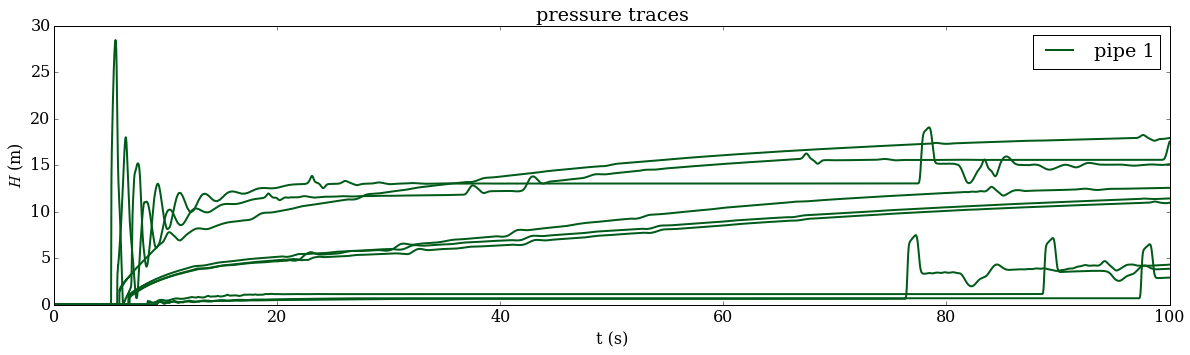

In [64]:
fig,ax = plt.subplots(nrows=1, figsize=(20,5))
t = linspace(0,T,M/Mi)
JJ = 1
for k in range(9):
    plot(t,H5[k*Np+JJ,:],color = scalarMap.to_rgba(JJ),lw = 2)
ylabel(r'$H$ (m)')
xlabel('t (s)')
legend(['pipe %d'%JJ],loc = 'upper right')
title('pressure traces')

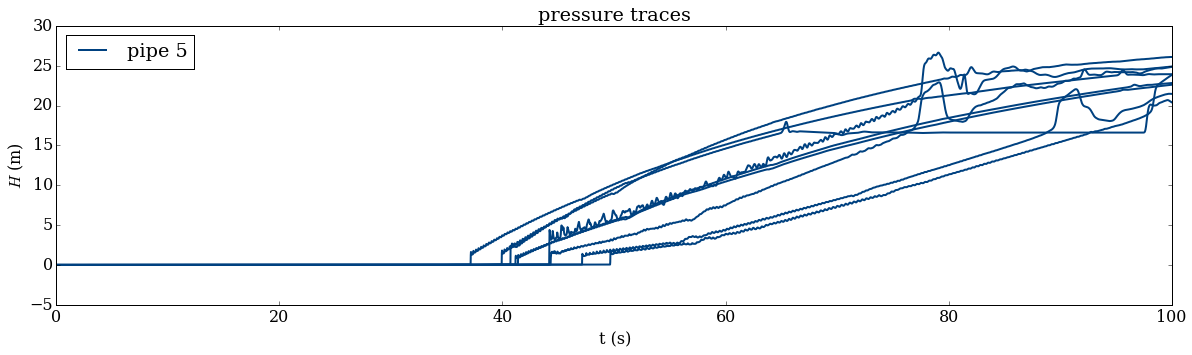

In [68]:
fig,ax = plt.subplots(nrows=1, figsize=(20,5))
t = linspace(0,T,M/Mi)
JJ = 5
for k in range(9):
    plot(t,H5[k*Np+JJ,:],color = scalarMap.to_rgba(JJ),lw = 2)
ylabel(r'$H$ (m)')
xlabel('t (s)')
legend(['pipe %d'%JJ],loc = 'upper left')
title('pressure traces')

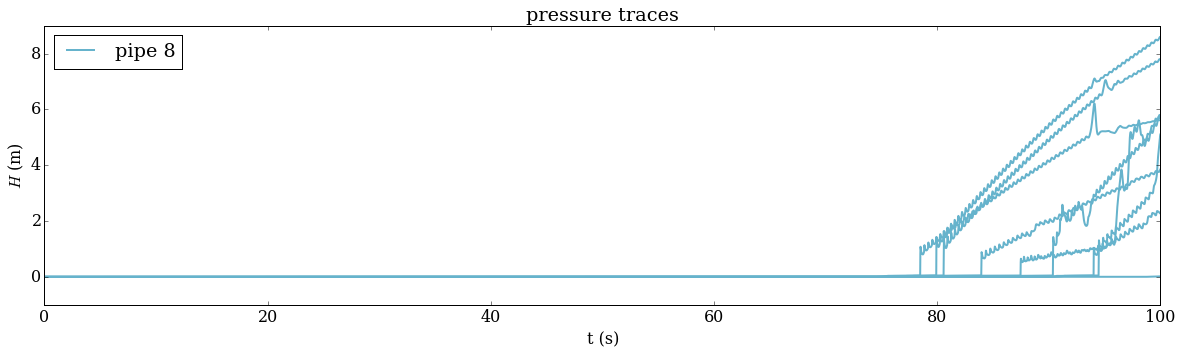

In [66]:
fig,ax = plt.subplots(nrows=1, figsize=(20,5))
t = linspace(0,T,M/Mi)
JJ = 8
for k in range(9):
    plot(t,H5[k*Np+JJ,:],color = scalarMap.to_rgba(JJ),lw = 2)
ylabel(r'$H$ (m)')
xlabel('t (s)')
legend(['pipe %d'%JJ],loc = 'upper left')
title('pressure traces')